# Experience : Risk a l'aversion

In [157]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [158]:
import sys
import os
# Ajouter le dossier src au chemin d'importation
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

In [159]:
import matplotlib.pyplot as plt
import torch 
import numpy as np

In [160]:
from environments.risk_aversion_env import RiskAversionEnvironment
from models.qlearning import QLearning

### Configuration de l'environnement

In [161]:
# Configuration de l'environnement
initial_energy = torch.tensor([10.0])  # Énergie initiale de l'agent
setpoint_energy = torch.tensor([50])  # Setpoint pour l'énergie optimale
weights = torch.tensor([1.0])  # Poids pour l'énergie interne
exponents = [2, 2]  # Non-linéarité du drive
effects = {}  # Placeholder pour les effets
energy_threshold = 5000

# Récompenses risquées et non risquées
risky_reward = 8  # Énergie ajoutée pour l'état risqué
non_risky_reward = 2  # Énergie ajoutée pour l'état non risqué
risky_probability = 0.2  # Probabilité d'obtenir l'énergie dans l'état risqué

# Instanciation de l'environnement
env = RiskAversionEnvironment(
    H=initial_energy,
    setpoints=setpoint_energy,
    weights=weights,
    exponents=exponents,
    effects=effects,
    risky_reward=risky_reward,
    non_risky_reward=non_risky_reward,
    risky_prob=risky_probability,
    energy_threshold = energy_threshold,
)

### Configuration de l'agent

In [162]:
# Création de la Q-table pour l'expérience aversion au risque
Q_table = {
    0: np.zeros(2),  # État non risqué avec 2 actions : rester (a_0) ou changer d'état (a_1)
    1: np.zeros(2),  # État risqué avec 2 actions : rester (a_0) ou changer d'état (a_1)
    #2: np.zeros(1),  # État terminal 
}

# Initialisation des valeurs Q pour encourager l'exploration initiale
Q_table[0][0] = 1  # Action "rester" dans l'état non risqué
Q_table[0][1] = 1  # Action "changer d'état" depuis l'état non risqué
Q_table[1][0] = 1  # Action "rester" dans l'état risqué
Q_table[1][1] = 1  # Action "changer d'état" depuis l'état risqué

# Instancier l'agent Q-learning
state_size = 2
action_size = 2  

alpha = 0.1  # Taux d'apprentissage
gamma = 0.1  # Facteur d'actualisation
epsilon = 0.1  # Taux d'exploration

agent = QLearning(state_size=state_size, action_size=action_size, alpha=alpha, gamma=gamma, epsilon=epsilon, q_table=Q_table)

### Entraînement du modèle

In [163]:
# Configuration pour l'apprentissage
episodes = 1000  # Nombre total d'épisodes
reward_history = []  # Récompenses cumulées par épisode
state_history = []  # Historique des états par épisode
internal_states = []  # Historique des états internes par épisode

for episode in range(episodes):
    state = env.reset()  # Réinitialiser l'environnement
    total_reward = 0  # Récompense totale pour l'épisode
    episode_states = []  # Historique des états pour cet épisode
    episode_internal_states = []  # Historique des états internes pour cet épisode
    done = False

    while not done:
        # Sauvegarder l'état courant
        episode_states.append(state)

        # Suivre l'état interne
        episode_internal_states.append(env.state.item())

        # Choisir une action
        action = agent.choose_action(state)

        # Effectuer une étape
        next_state, reward, done, _ = env.step(action)

        # Mise à jour Q-learning
        agent.update_q_value(state, action, reward, next_state)

        # Mettre à jour l'état courant
        state = next_state
        total_reward += reward

    # Ajouter les métriques de l'épisode aux historiques globaux
    reward_history.append(total_reward)
    state_history.append(episode_states)
    internal_states.append(episode_internal_states)

    print(f"Épisode {episode + 1}/{episodes} : Récompense totale = {total_reward}, Nombre de steps = {len(episode_states)}")


Épisode 1/1000 : Récompense totale = -70962620.0, Nombre de steps = 2809
Épisode 2/1000 : Récompense totale = -68464720.0, Nombre de steps = 2775
Épisode 3/1000 : Récompense totale = -67801000.0, Nombre de steps = 2703
Épisode 4/1000 : Récompense totale = -67110560.0, Nombre de steps = 2737
Épisode 5/1000 : Récompense totale = -69578180.0, Nombre de steps = 2692
Épisode 6/1000 : Récompense totale = -66667220.0, Nombre de steps = 2679
Épisode 7/1000 : Récompense totale = -71194820.0, Nombre de steps = 2899
Épisode 8/1000 : Récompense totale = -68826200.0, Nombre de steps = 2691
Épisode 9/1000 : Récompense totale = -68339020.0, Nombre de steps = 2732
Épisode 10/1000 : Récompense totale = -70163160.0, Nombre de steps = 2792
Épisode 11/1000 : Récompense totale = -67624040.0, Nombre de steps = 2717
Épisode 12/1000 : Récompense totale = -68962680.0, Nombre de steps = 2760
Épisode 13/1000 : Récompense totale = -69524940.0, Nombre de steps = 2783
Épisode 14/1000 : Récompense totale = -69294260

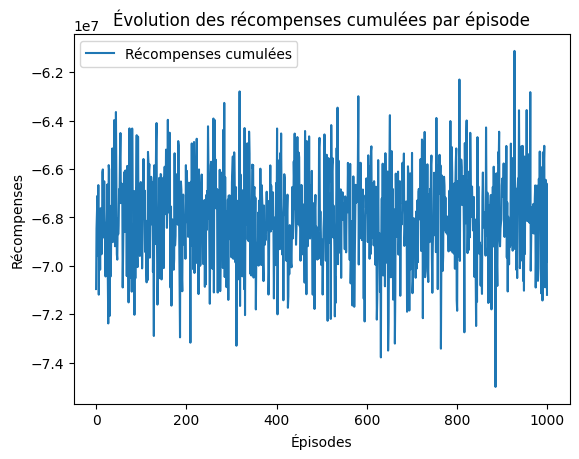

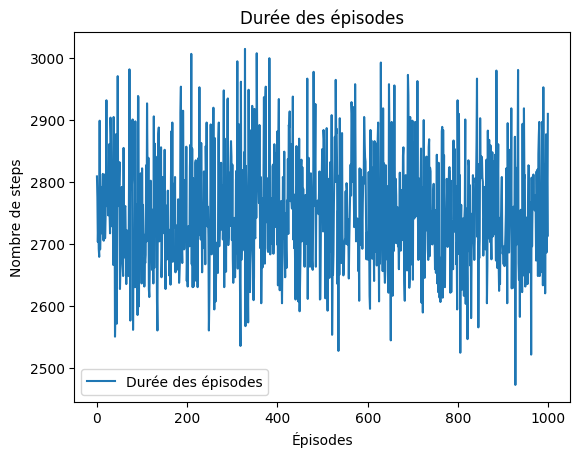

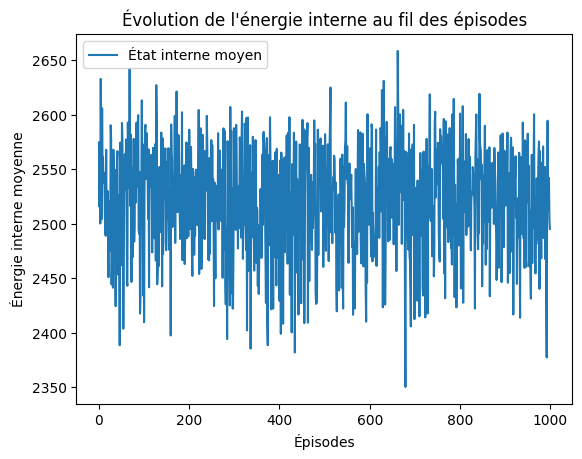

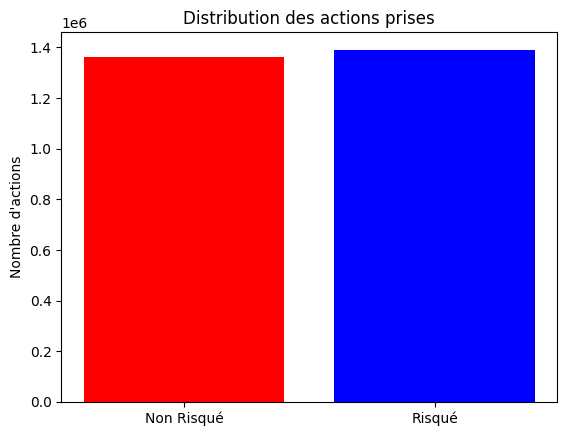

In [164]:
plt.plot(reward_history, label="Récompenses cumulées")
plt.xlabel("Épisodes")
plt.ylabel("Récompenses")
plt.title("Évolution des récompenses cumulées par épisode")
plt.legend()
plt.show()


episode_lengths = [len(states) for states in state_history]

plt.plot(episode_lengths, label="Durée des épisodes")
plt.xlabel("Épisodes")
plt.ylabel("Nombre de steps")
plt.title("Durée des épisodes")
plt.legend()
plt.show()

average_internal_states = [sum(states) / len(states) for states in internal_states]

plt.plot(average_internal_states, label="État interne moyen")
plt.xlabel("Épisodes")
plt.ylabel("Énergie interne moyenne")
plt.title("Évolution de l'énergie interne au fil des épisodes")
plt.legend()
plt.show()


action_counts = {0: 0, 1: 0}  # Compteurs pour les actions non risquées et risquées

for episode_states in state_history:
    for state in episode_states:
        if state == 0:
            action_counts[0] += 1
        elif state == 1:
            action_counts[1] += 1

# Affichage de la distribution des actions
plt.bar(["Non Risqué", "Risqué"], [action_counts[0], action_counts[1]], color=["red", "blue"])
plt.title("Distribution des actions prises")
plt.ylabel("Nombre d'actions")
plt.show()


In [165]:
# import tqdm

# # Nombre d'agents
# nb_agents = 10  # Par exemple, 10 agents

# # Création des agents
# agents = []
# for i in range(nb_agents):
#     agent = QLearning(state_size=state_size, action_size=action_size, alpha=alpha, gamma=gamma, epsilon=epsilon, q_table=Q_table)
#     agents.append(agent)

# # Initialisation des états des Q-tables et des états internes
# max_epoch = 500
# q_table_state = [[] for _ in range(max_epoch)]
# q_table_state[0] = [agent.q_table[0].copy() for agent in agents]

# internal_states = [[[] for _ in range(nb_agents)] for _ in range(max_epoch)]  # Suivi des états internes

# # Variables pour suivre les choix d'actions
# risky_action_counts = 0
# non_risky_action_counts = 0

# # Boucle sur les époques
# for epoch in tqdm.tqdm(range(max_epoch), leave=True, position=0, desc="Epoch"):
#     risky_action_counts = 0
#     non_risky_action_counts = 0

#     for i, agent in enumerate(agents):
#         # Réinitialiser l'environnement pour chaque agent
#         state = env.reset()
#         done = False
#         total_reward = 0

#         while not done:
#             # Choisir une action
#             action = agent.choose_action(state)

#             # Effectuer une étape dans l'environnement
#             next_state, reward, done, _ = env.step(action)

#             # Mise à jour Q-learning
#             agent.update_q_value(state, action, reward, next_state)

#             # Mettre à jour l'état courant
#             state = next_state
#             total_reward += reward

#             # Compter les actions risquées et non risquées
#             if action == 0:
#                 non_risky_action_counts += 1
#             elif action == 1:
#                 risky_action_counts += 1

#         # Enregistrer l'état de la Q-table de l'agent pour cette époque
#         q_table_state[epoch].append(agent.q_table[0].copy())

#         # Suivre l'état interne
#         internal_states[epoch][i].append(env.state.item())

#     # Affichage des résultats pour l'époque
#     print(f"Epoch {epoch}: {risky_action_counts} risky actions, {non_risky_action_counts} non risky actions")


In [166]:
# plt.plot(reward_history)

In [167]:
# # 0: non risqué, 1: risqué
# un = 0
# zero = 0
# for state in state_history:
#     if state==0: 
#         zero+=1
#     else:
#         un+=1
# print("nombre d'iteration ou l'agent choisit le choix risqué  : ",un)
# print("nombre d'iteration ou l'agent choisit le choix non risqué : ",zero)

In [168]:
# # non_risky_pref = [1 if s == 0 else 0 for s in state_history]
# # risky_pref = [1 if s == 1 else 0 for s in state_history]

# # # Graphique des préférences
# # plt.plot(non_risky_pref, label="Préférence non risqué (rouge)", color="red")
# # plt.plot(risky_pref, label="Préférence risqué (bleu)", color="blue")
# # plt.xlabel("Time")
# # plt.ylabel("Préférence")
# # plt.legend()
# # plt.title("Préférence pour les états au fil du temps")
# # plt.show()

# # Graphique de l'état interne
# plt.plot(range(0,20),internal_states[:20], label="État interne", color="green")
# plt.xticks(range(0, 20))
# plt.xlabel("Time")
# plt.ylabel("Énergie interne")
# plt.title("Évolution de l'énergie interne au fil du temps")
# plt.show()